In [1]:
from rl.rl_env import MainEnv
import pandas as pd
import torch
from torch import nn
import numpy as np

In [2]:
data = pd.read_pickle('/Users/ruagmn9/PycharmProjects/raif-bootcamp-2021/data/data_train.pkl')

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
train_data, test_data = train_test_split(data, stratify=data['reward'])

In [5]:
env, test_env = MainEnv(data), MainEnv(test_data)

In [6]:
obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)


Observation shape: (5, 768)
Num actions: 5


/Users/ruagmn9/Library/Caches/pypoetry/virtualenvs/deeppavlov-test-8ztkSxjl-py3.7/lib/python3.7/site-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


## POMDP setting

In [7]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

In [8]:
from rl.agent import SimpleNNAgent

In [9]:
n_parallel_games = 5
gamma = 0.99

agent = SimpleNNAgent(obs_shape, n_actions)

In [10]:
state = [env.reset()]
logits, value = agent.step(state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 tensor([[-0.2266, -0.5875, -0.1315, -0.2802, -0.1669]])
state values:
 tensor([[0.1796]])


# eval

In [11]:
def evaluate(agent, env, n_games=1):
    """Plays an entire game start to end, returns session rewards."""

    game_rewards = []
    for _ in range(n_games):
        # initial observation and memory
        observation = env.reset()

        total_reward = 0
        while True:
            readouts = agent.step(observation[None, ...])
            action = agent.sample_actions(readouts)
            observation, reward, done, info = env.step(action[0])

            total_reward += reward
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

In [12]:
rw = evaluate(agent, env, n_games=100,)



# Training on parallel games

In [22]:
def make_env():
    return MainEnv(data)

In [23]:
from rl.env_pool import EnvPool
pool = EnvPool(agent, make_env, n_parallel_games)

In [24]:
# for each of n_parallel_games, take 10 steps
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)

In [25]:
print("Actions shape:", rollout_actions.shape)
print("Rewards shape:", rollout_rewards.shape)
print("Mask shape:", rollout_mask.shape)
print("Observations shape: ", rollout_obs.shape)

Actions shape: (5, 10)
Rewards shape: (5, 10)
Mask shape: (5, 10)
Observations shape:  (5, 10, 5, 768)


#  Actor-critic objective

In [26]:
def to_one_hot(y, n_dims=None):
    """ Take an integer tensor and convert it to 1-hot matrix. """
    y_tensor = y.to(dtype=torch.int64).reshape(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [28]:
opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

def train_on_rollout(states, actions, rewards, is_not_done,
                      gamma=0.99,
                     device=device, max_grad_norm=90,
                     entropy_coef=0.01):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # shape: [batch_size, time, c, h, w]
    states = torch.tensor(np.asarray(states), dtype=torch.float32)
    actions = torch.tensor(np.array(actions), dtype=torch.int64)  # shape: [batch_size, time]
    rewards = torch.tensor(np.array(rewards), dtype=torch.float32)  # shape: [batch_size, time]
    is_not_done = torch.tensor(np.array(is_not_done), dtype=torch.float32)  # shape: [batch_size, time]
    rollout_length = rewards.shape[1] - 1

    # predict logits, probas and log-probas using an agent.
    logits = []  # append logit sequence here
    state_values = []  # append state values here
    for t in range(rewards.shape[1]):
        obs_t = states[:, t]
        #print(obs_t.size())
        # use agent to comute logits_t and state values_t.
        # append them to logits and state_values array

        (logits_t, values_t) = agent.forward(obs_t)
        # <YOUR CODE >

        logits.append(logits_t)
        state_values.append(values_t)

    logits = torch.stack(logits, dim=1)
    state_values = torch.stack(state_values, dim=1)
    probas = F.softmax(logits, dim=2)
    logprobas = F.log_softmax(logits, dim=2)

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    actions_one_hot = to_one_hot(actions, n_actions).view(
        actions.shape[0], actions.shape[1], n_actions)
    logprobas_for_actions = torch.sum(logprobas * actions_one_hot, dim=-1)

    # Now let's compute two loss components:
    # 1) Policy gradient objective.
    # Notes: Please don't forget to call .detach() on advantage term. Also please use mean, not sum.
    # it's okay to use loops if you want
    J_hat = 0  # policy objective as in the formula for J_hat

    # 2) Temporal difference MSE for state values
    # Notes: Please don't forget to call on V(s') term. Also please use mean, not sum.
    # it's okay to use loops if you want
    value_loss = 0
    cumulative_returns = state_values[:, -1].detach()
    for t in reversed(range(rollout_length)):
        r_t = rewards[:, t].view(-1,1)                               # current rewards
        # current state values
        V_t = state_values[:, t]
        V_next = state_values[:, t + 1].detach()          # next state values
        # log-probability of a_t in s_t
        logpi_a_s_t = logprobas_for_actions[:, t].view(-1, 1)
        
        # update G_t = r_t + gamma * G_{t+1} as we did in week6 reinforce
        cumulative_returns = G_t = r_t + gamma * cumulative_returns
        # Compute temporal difference error (MSE for V(s))
        #print(r_t.size())
        # compute advantage A(s_t, a_t) using cumulative returns and V(s_t) as baseline
        
        value_loss += F.mse_loss(V_t, r_t + gamma * V_next)# <YOUR CODE >

          
        
        
        advantage = cumulative_returns - V_t  #<YOUR CODE >
        advantage = advantage.detach()

        # compute policy pseudo-loss aka -J_hat.
        J_hat += torch.mean(logpi_a_s_t * advantage) # <YOUR CODE >

    entropy_reg = -torch.mean(torch.mean(torch.sum(probas*logprobas, dim=-1), dim=1))  #<compute entropy regularizer >
    # add-up three loss components and average over time

    loss = (
         - (J_hat / rollout_length)
         + (value_loss / rollout_length)
         - (entropy_coef * entropy_reg)
            )

    # Gradient descent step
    loss.backward()
    # This small trick allows to clip gradients and to monitor them over the time
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    # < your code >
    opt.step()
    opt.zero_grad()

    return loss.data.numpy(), grad_norm, entropy_reg.data.numpy()

In [29]:
# let's test it
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)

train_on_rollout(rollout_obs, rollout_actions,
                 rollout_rewards, rollout_mask)

(array(0.0435479, dtype=float32),
 tensor(1.2409),
 array(1.5901424, dtype=float32))

## Train

In [30]:
from IPython.display import clear_output
from tqdm import trange
import matplotlib.pyplot as plt
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

rewards_history = []
grad_norm_history = []
entropy_history = []
loss_history = []

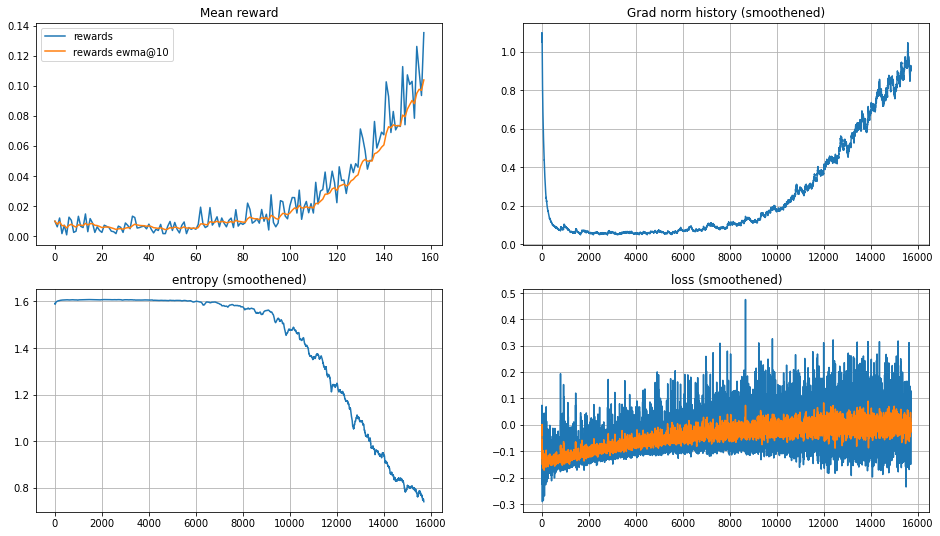

In [ ]:
entropy_coef = 1e-1
n_steps = 10
for i in range(15000, 250000):

    rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(
        n_steps)
    loss, grad_norm, entropy = train_on_rollout(rollout_obs, rollout_actions,
                                                rollout_rewards, rollout_mask,
                                                entropy_coef=entropy_coef)
    grad_norm_history.append(grad_norm)
    entropy_history.append(entropy)
    loss_history.append(loss)

    if i % 100 == 0:
        if i <= 21000:
            if i % 500 == 0:
                n_steps += 1
        entropy_coef = entropy_coef / 1.02
        
            
            
            
        current_reward = np.mean(evaluate(agent, test_env, n_games=100))
#         if current_reward >= 14000:
#             print('not bad')
#             entropy_coef = 0
        rewards_history.append(current_reward)
        clear_output(True)
        
        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Mean reward")
        plt.plot(rewards_history, label='rewards')
        plt.plot(moving_average(np.array(rewards_history),
                                span=10), label='rewards ewma@10')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.title("Grad norm history (smoothened)")
        plt.plot(moving_average(np.array(grad_norm_history), span=100), label='grad norm ewma@100')
        plt.grid()
        
        plt.subplot(2, 2, 3)
        plt.title("entropy (smoothened)")
        plt.plot(moving_average(np.array(entropy_history), span=100), label='entropy ewma@100')
        plt.grid()
        
        plt.subplot(2, 2, 4)
        plt.title("loss (smoothened)")
        plt.plot(np.array(loss_history), label='loss raw')
        plt.plot(moving_average(np.array(loss_history), span=10), label='loss ewma@10')
        plt.grid()


        plt.show()
        


In [29]:
data['pred'] = data['state'].apply(lambda x: agent.sample_greedy(agent.step(x[None, ...])))

(data['answer_index'] == data['pred']).sum() / data.shape[0]

## test

In [25]:
PATH = '/Users/ruagmn9/PycharmProjects/raif-bootcamp-2021/model_data/torch_model'

In [26]:
torch.save(agent.state_dict(), PATH)


In [ ]:
the_model = TheModelClass(*args, **kwargs)


In [27]:
ag = SimpleNNAgent(obs_shape, n_actions)

In [28]:
obs_shape

(5, 768)

In [29]:
n_actions

5

In [31]:

ag.load_state_dict(torch.load(PATH))

<All keys matched successfully>

False